In [1]:
import os 
import numpy as np
import healpy as hp
import mtneedlet as nl
import broom
import matplotlib.pyplot as plt
from types import SimpleNamespace
from dataclasses import replace

from broom import (
    Configs,
    get_params,
    component_separation,_get_full_simulations, estimate_residuals)
from broom._needlets import _get_needlet_windows_
from broom.clusters import get_and_save_real_tracers_B
from IPython.display import Markdown


### 📘 Introduction to Configuration Parameters

See [`configs/config_demo.yaml`](./configs/config_demo.yaml) and the notebook [`tutorial_satellite.ipynb`](./tutorial_satellite.ipynb) for a detailed explanation of all configuration options.

---

### 🛰️ Tutorial: Simulations Generation

An example of simulations generation is provided in the notebook:  
[`tutorial_satellite.ipynb`](./tutorial_satellite.ipynb)

In [2]:
# Importing all general parameter from satellite config file

root_path = os.path.dirname(os.path.dirname(os.path.abspath(broom.__file__)))
config_path = root_path + "/configs/config_satellite.yaml"

config: Configs = get_params(config_path=config_path)
print("Loaded configuration from\n", config_path)

Loaded configuration from
 /home/alecarones/Post-Doc/develop_code_nilcs/configs/config_satellite.yaml


In [3]:
# Generation or loading of input simulations

data = _get_full_simulations(config, nsim = 0)


Generating foreground maps of d1s1 model


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Generating CMB simulation 00000
Generating noise simulation 00000
Generating coadded signal for simulation 00000


## Running GILC 

Blind reconstruction of foreground emission at the frequencies of interest

In [12]:
# Configuration for running GILC.
# It can be applied also in pixel domain.

config_run = {
    'compsep': [{
    # Method to be applied
    'method': "gilc",
    # Domain in which the method is applied
    'domain': "needlet",
    # Needlet configuration to be used if domain is "needlet"
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0,10,14,17,40]}],
    # Amount of residual ILC bias. It is used to set the size of domain where covariance is computed. 
    # If 0., covariance is computed as the average over the full sky/patch.
    'ilc_bias': 0.001,
    # If True, needlet bands are squared. Therefore needlet transformation is performed just once before component separation. 
    'b_squared': False,
    # If True, the HEALPix resolution of needlet maps is adapted to the sampled range of multipoles.    
    'adapt_nside': True,
    # If False, the CMB is not included in the nuisance covariance (and therefore possibly not deprojected)
    'cmb_nuisance': True,
    # If not null in some elements, it will set a deprojection coefficient 
    # for the CMB in the correppsonding needlet band, i.e. cmb_residuals = depro_cmb * cmb_input
    'depro_cmb': [None, None, None], #[None,0.,0.,0.]
    # If not zero, it will include m_bias more (if m_bias > 0) 
    # or less (if m_bias < 0) modes in the reconstructed GNILC maps. Default is 0.
    # It can be a list if different values are needed for different needlet bands.
    'm_bias': [0,0,0,0],
    # Indices of channels you want to be reconstructed with GNILC. 
    # If not provided, all channels are reconstructed.
    'channels_out': [i for i in range(len(config.instrument.frequency))],
    # If True, needlet bands are saved in the path specified in path_outputs.  
    'save_needlets': False,
    # If different from 0. it will debias the covariance matrix by a factor cov_noise_debias * noise_covariance.
    # If float, it will be applied to all needlet bands.
    # If a list each element will be applied to corresponding needlet band.
    # Default = 0.
    'cov_noise_debias': [0.,0.,0.,0.]
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes

# data.nuisance = data.cmb + data.noise
outputs_gilc = component_separation(config, data, nsim = 0)


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running gilc in needlet domain for simulation 00000.
Using nuisance alms with indices: 3


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

Size of the outputs is (1, 22, 49152)


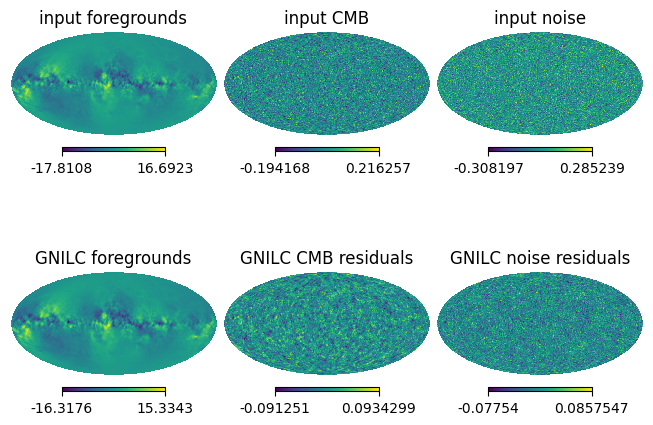

In [13]:
# Let's compare output and input foreground emission

print(f'Size of the outputs is {outputs_gilc.total.shape}')

idx_field = {"T": 0, "E": 1, "B": 2}

freq_idx = 12
field = idx_field[config.field_out]

# data_type is "alms" - inputs
fgds = hp.alm2map(data.fgds[freq_idx,field],config.nside,lmax=config.lmax)
noise = hp.alm2map(data.noise[freq_idx,field],config.nside,lmax=config.lmax)
cmb = hp.alm2map(data.cmb[freq_idx,field],config.nside,lmax=config.lmax)

plt.figure()
# inputs
hp.mollview(fgds, title="input foregrounds", sub=(2,3,1))
hp.mollview(cmb, title="input CMB", sub=(2,3,2))
hp.mollview(noise, title="input noise", sub=(2,3,3))
# GNILC outputs
hp.mollview(outputs_gilc.fgds[0,freq_idx], title="GNILC foregrounds", sub=(2,3,4))
hp.mollview(outputs_gilc.cmb[0,freq_idx], title="GNILC CMB residuals", sub=(2,3,5))
hp.mollview(outputs_gilc.noise[0,freq_idx], title="GNILC noise residuals", sub=(2,3,6))


## 🌌 Estimate Foreground Residuals

### The GNILC templates generated in the previous step are now employed to estimate residuals in the component-separated maps.


In [14]:
# Let's perform a NILC run (details in tutorial_satellite.ipynb)

# NILC weights need to be saved in order to then estimate fgds residuals.

config_run = {
    'compsep': [{'method': "ilc", 'domain': "needlet", 'ilc_bias': 0.001,
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0, 14, 17, 19, 40]}],
    'adapt_nside': True, 'save_needlets': True, 'save_weights': True,
}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes

outputs_nilc = component_separation(config, data, nsim = 0)


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running ilc in needlet domain for simulation 00000.


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [15]:
# To estimate foreground residuals we need to set the 'compsep_residuals' dictionary

config_res_run = {
    'compsep_residuals': [{'gnilc_path': "gilc_needlet_bias0.001/mexican_B1.3_j0j9_j10j13_j14j16_j17j39", 
    'compsep_path': "ilc_needlet_bias0.001/mexican_B1.3_j0j13_j14j16_j17j18_j19j39",
    'adapt_nside': True
}]}

config.config["compsep_residuals"] = config_res_run["compsep_residuals"]
config._store_passed_settings()   #

outputs_res = estimate_residuals(config, nsim=0)

Running foregrounds residuals estimation for simulation 00000.
Path /home/alecarones/Post-Doc/develop_code_nilcs/outputs/LiteBIRD_PTEP/d1s1/gilc_needlet_bias0.001/mexican_B1.3_j0j9_j10j13_j14j16_j17j39/fgds_residuals/00000 contains the expected foregrounds residuals. The ideal template of foregrounds residuals with no CMB and noise contamination will be computed
Inputs are assumed to be at common angular resolution
Correcting for input pixel window function


setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


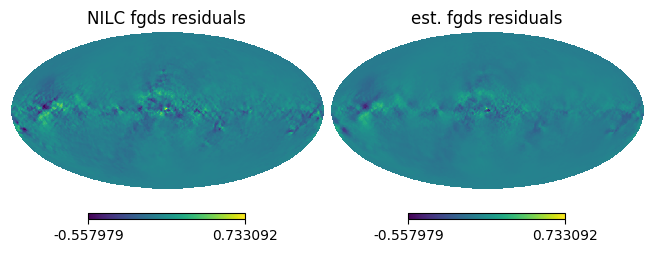

In [16]:
plt.figure()
hp.mollview(outputs_nilc.fgds[0], title="NILC fgds residuals", sub=(1,2,1),min=np.min(outputs_nilc.fgds[0]),max=np.max(outputs_nilc.fgds[0]))
hp.mollview(outputs_res.fgds[0], title="est. fgds residuals", sub=(1,2,2),min=np.min(outputs_nilc.fgds[0]),max=np.max(outputs_nilc.fgds[0]))


## 🧪 Diagnosing Foreground Complexity

Perform diagnostics of **foreground complexity**  
(see [arXiv:2402.17579](https://arxiv.org/abs/2402.17579) for detailed methodology).

In [4]:
# Configuration for foreground diagnostic of scalar fields.
# In this case, we consider only B-modes as config.fiel_out is set to 'B'.

config_run = {
    'compsep': [{
    # Method to be applied
    'method': "fgd_diagnostic",
    # Domain in which the method is applied
    'domain': "needlet",
    # Needlet configuration to be used if domain is "needlet"
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0,10,14,17,40]}],
    # It sets the size of domain where covariance is computed. 
    # If 0., covariance is computed as the average over the full sky/patch and
    # it will return a single value of fgd complexity across the sky
    'ilc_bias': 0.1,
    # If True, needlet bands are squared. 
    'b_squared': False,
    # If True, the HEALPix resolution of needlet maps is adapted to the sampled range of multipoles.    
    'adapt_nside': True,
    # If False, the CMB is not included in the nuisance covariance and 
    # therefore it could be included in the number of foreground modes depending on the CMB to noise ratio.
    'cmb_nuisance': True,
    # If True, needlet bands are saved in the path specified in path_outputs.  
    'save_needlets': True,
    'cov_noise_debias': [0.,0.,0.,0.]

}]}

config.config["compsep"] = config_run["compsep"]
config._store_passed_settings()   # refresh all dependent attributes

diagnostic_maps = component_separation(config, data, nsim = 0)


Pre-processing input alms for component separation for simulation 00000.
Bringing inputs to common resolution
Correcting for input pixel window function
Running component separation for simulation 00000.
Running fgd_diagnostic in needlet domain for simulation 00000.
No nuisance alms provided. Using input noise and CMB alms as nuisance.


/home/alecarones/Post-Doc/develop_code_nilcs/broom/_inputs.py:450: RuntimeWarning: divide by zero encountered in divide
  pixwin_inv = 1. / np.array(hp.pixwin(config.nside_in, pol=True, lmax=config.lmax))
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


In [5]:
print(f'Attributes of "outputs_ilc" are {", ".join(vars(diagnostic_maps).keys())}')

print(f"'m' shape is {diagnostic_maps.m.shape}")

Attributes of "outputs_ilc" are m
'm' shape is (1, 4, 49152)


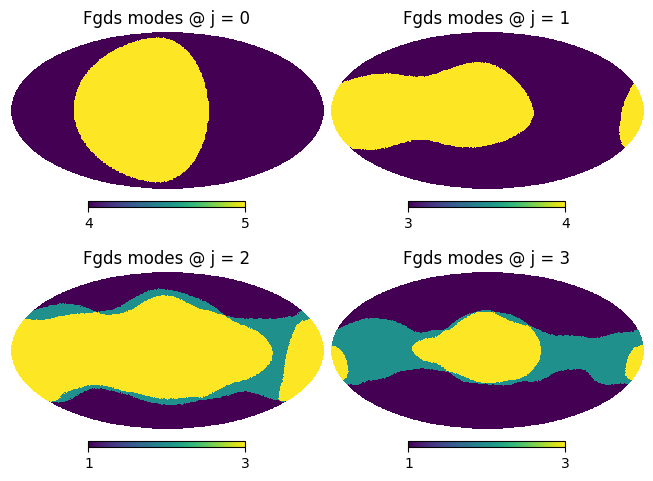

In [6]:
plt.figure()
# inputs
for k in range(diagnostic_maps.m.shape[1]):
    hp.mollview(diagnostic_maps.m[0,k], title=f"Fgds modes @ j = {k}", sub=(2,2,k+1))


## Extension to Polarization Intensity

As shown in [`tutorial_satellite.ipynb`](./tutorial_satellite.ipynb),  
the methodologies described above can also be applied to **polarization intensity**.

The **estimate of foreground residuals** is run in this case as shown in the cell above, the compsep_path should only be adapted accordingly

In [ ]:
# GPILC run

config_gpilc = {
    'compsep': [{
    'method': "gpilc",
    'domain': "needlet",
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0,10,14,17,40]}],
    'ilc_bias': 0.01,
    'cmb_nuisance': True,
    'depro_cmb': [None, None, None], #[None,0.,0.,0.]
    'm_bias': [0,0,0,0],
    'channels_out': [i for i in range(len(config.instrument.frequency))],
    'save_needlets': False,
}]}

# FGD diagnostic in Polarization intensity

config_run = {
    'compsep': [{
    'method': "fgd_P_diagnostic",
    'domain': "needlet",
    'needlet_config':
      [{'needlet_windows': "mexican"},
       {'width': 1.3},
       {'merging_needlets': [0,10,14,17,40]}],
    'ilc_bias': 0.1,
    'cmb_nuisance': True,
    'save_needlets': False,
}]}
